# PPAC Analysis Notebook

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
%matplotlib widget


## Load Data

In [2]:
data_dir = 'correlations/all_isobutane_1_hit_square'
data_paths = {
    "coincident": Path(f"{data_dir}/coincident_imp.pkl"),
    "decay_candidates": Path(f"{data_dir}/decay_candidates.pkl"),
    "final_correlated": Path(f"{data_dir}/final_correlated.pkl"),
}
data = {}
for name, path in data_paths.items():
    if path.exists():
        data[name] = pd.read_pickle(path)
        print(f"Loaded {name}: {len(data[name])} rows")
    else:
        print(f"File {path} not found")
        
        
decays = data["decay_candidates"]    
coincident = data["coincident"]  
df = data["final_correlated"]
df_RA = df[df['chain']=='RA']
df_RE = df[df['chain']=='RE']
df_RAA = df[df['chain']=='RAA']
df_REA = df[df['chain']=='REA']
df_REAA = df[df['chain']=='REAA']

Loaded coincident: 941743 rows
Loaded decay_candidates: 117133 rows
Loaded final_correlated: 99162 rows


# all energies


Text(0, 0.5, 'Counts/ 10keV')

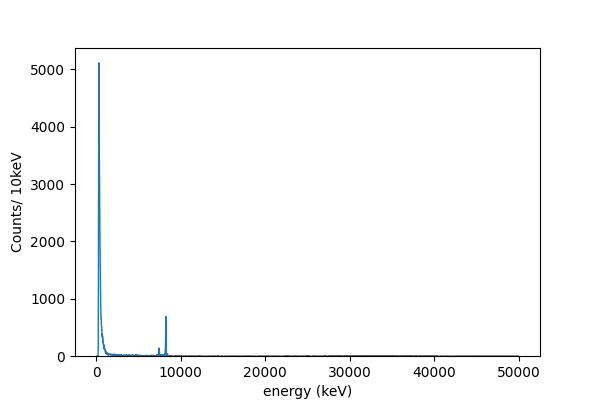

In [3]:
plt.figure(figsize=(6,4))

# plt.hist(coincident['imp_xE'], histtype='step', bins=2000, range=(0,20000)) #10keV
plt.hist(decays['xE'], histtype='step', bins=5000, range=(0,50000))
plt.xlabel('energy (keV)')
plt.ylabel(r'Counts/ 10keV')
# plt.xlim(10e3,30e3)
# plt.xlim(4e3,10e3)
# plt.ylim(bottom=0,top=50)
# plt.yscale('log')

# RA

Text(0, 0.5, 'Counts/ 40keV')

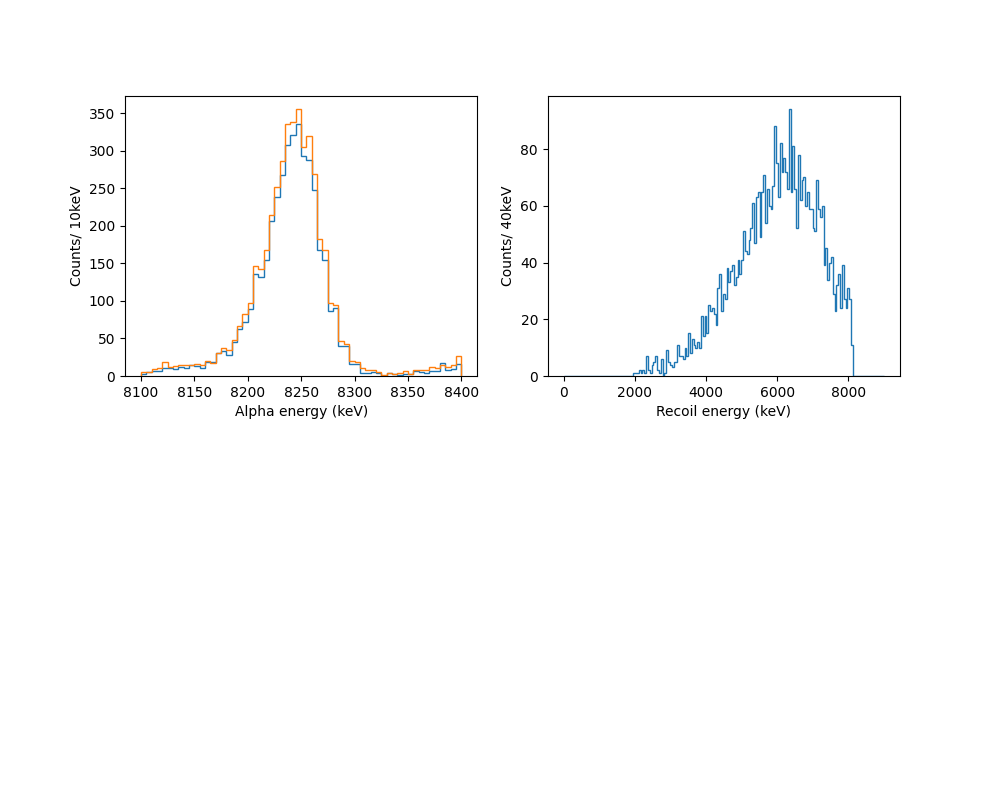

In [4]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(decays['xE'], histtype='step', bins=60, range=(8100,8400))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

plt.subplot(222)
plt.hist(df_RA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Recoil energy (keV)')
plt.ylabel(r'Counts/ 40keV')

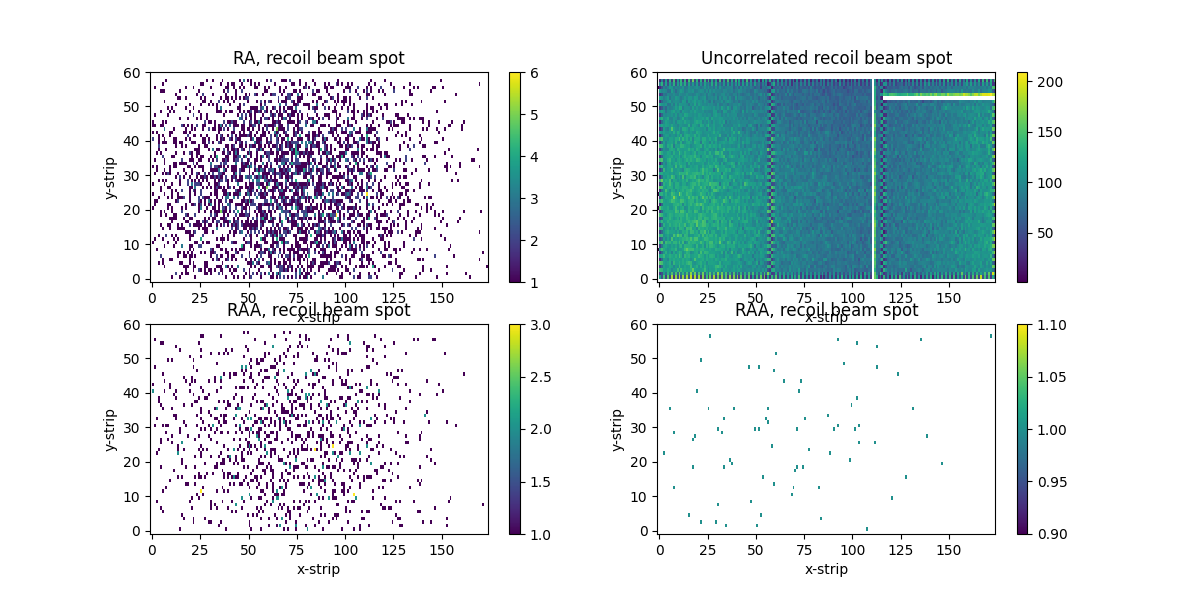

In [5]:
# # correlated beam spot
plt.figure(figsize=(12,6))
# plt.subplots_adjust(hpsace=0.3)
plt.subplot(221)
plt.hist2d(df_RA['recoil_x'], df_RA['recoil_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
plt.xlabel('x-strip')
plt.ylabel(r'y-strip')
plt.title(r'RA, recoil beam spot')
plt.colorbar()


plt.subplot(222)
plt.hist2d(coincident['imp_x'], coincident['imp_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlim(0, 10000)
plt.xlabel('x-strip')
plt.ylabel(r'y-strip')
plt.title(r'Uncorrelated recoil beam spot')
plt.colorbar()

plt.subplot(223)
plt.hist2d(df_RAA['recoil_x'], df_RAA['recoil_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
plt.xlabel('x-strip')
plt.ylabel(r'y-strip')
plt.title(r'RAA, recoil beam spot')
plt.colorbar()

plt.subplot(224)
plt.hist2d(df_REAA['recoil_x'], df_REAA['recoil_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
plt.xlabel('x-strip')
plt.ylabel(r'y-strip')
plt.title(r'RAA, recoil beam spot')
plt.colorbar()





# RAA

In [6]:
df_RAA = df[df['chain']=='RAA']
display(df_RAA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,electron1_x,electron1_y,electron1_t,electron1_xE,electron1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
226,95.0,20.0,7140.940765,8.612967e+13,8.612967e+13,0.0,8.612967e+13,16.0,8.612967e+13,0.0,...,NaN,NaN,NaN,NaN,NaN,95.0,20.0,124.273195,7396.641724,35.578376
227,97.0,19.0,5747.336024,1.039408e+14,1.039408e+14,0.0,NaN,NaN,1.039408e+14,0.0,...,NaN,NaN,NaN,NaN,NaN,97.0,19.0,267.178228,7374.271444,160.837018
228,81.0,13.0,4538.430259,3.329776e+14,3.329776e+14,118.0,3.329776e+14,0.0,3.329776e+14,9.0,...,NaN,NaN,NaN,NaN,NaN,81.0,13.0,769.206541,7438.565084,431.229301
229,65.0,46.0,6576.566208,4.247074e+14,4.247074e+14,110.0,4.247074e+14,0.0,4.247074e+14,8.0,...,NaN,NaN,NaN,NaN,NaN,65.0,46.0,631.790692,7464.640067,205.768927
2725,89.0,21.0,3842.515834,1.719625e+14,1.719625e+14,92.0,1.719625e+14,8.0,1.719625e+14,0.0,...,NaN,NaN,NaN,NaN,NaN,89.0,21.0,624.708761,7386.393557,448.956147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99152,40.0,20.0,7304.315487,3.561769e+15,3.561769e+15,3224.0,3.561769e+15,714.0,3.561769e+15,1204.0,...,NaN,NaN,NaN,NaN,NaN,40.0,20.0,3603.005651,7396.382260,40.722858
99153,79.0,31.0,5446.813292,3.597923e+15,3.597923e+15,3260.0,3.597923e+15,1051.0,3.597923e+15,805.0,...,NaN,NaN,NaN,NaN,NaN,79.0,31.0,3828.440799,7384.624923,229.987371
99154,111.0,27.0,6626.302938,3.683817e+15,3.683817e+15,3022.0,3.683817e+15,1245.0,3.683817e+15,379.0,...,NaN,NaN,NaN,NaN,NaN,111.0,27.0,3798.363355,7419.924242,104.877065
99155,79.0,8.0,6063.029465,3.693025e+15,3.693025e+15,3966.0,3.693025e+15,1304.0,3.693025e+15,1028.0,...,NaN,NaN,NaN,NaN,NaN,79.0,8.0,3954.141214,7412.364557,256.423264


(0.0, 700.0)

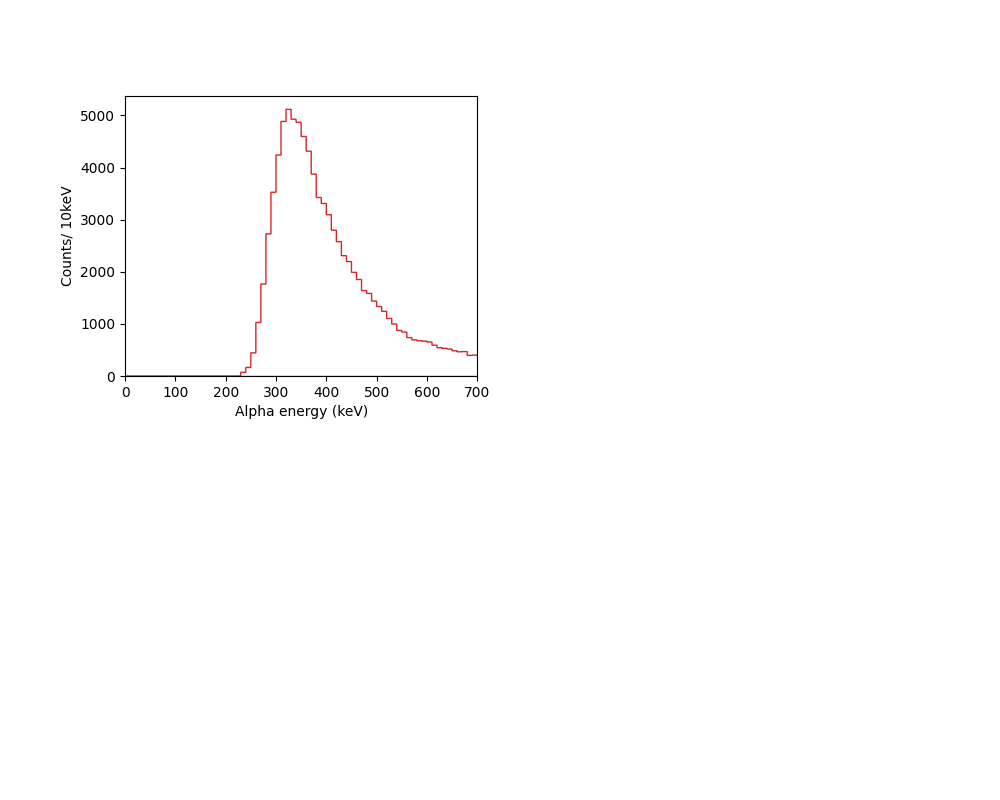

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RAA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(df_RAA['alpha2_xE'], histtype='step', bins=60, range=(7250,7550))
plt.hist(df_RAA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.hist(decays['xE'], histtype='step', bins=1000, range=(0,10e3))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')
# plt.xlim(7e3,9e3)
plt.xlim(0,700)
# plt.ylim(top=600)

# REAA

In [8]:
df_REAA = df[df['chain']=='REAA']
display(df_REAA)

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,electron1_x,electron1_y,electron1_t,electron1_xE,electron1_dt,alpha2_x,alpha2_y,alpha2_t,alpha2_xE,alpha2_dt
2782,102.0,54.0,5092.879504,1.724604e+15,1.724604e+15,0.0,1.724604e+15,10.0,1.724604e+15,0.0,...,103.0,53.0,1725.868989,399.307755,1.265230,102.0,54.0,1990.233748,7418.533628,261.666073
2783,49.0,29.0,6232.930004,2.522816e+15,2.522816e+15,99.0,2.522816e+15,5.0,2.522816e+15,0.0,...,49.0,28.0,2523.570463,643.607378,0.754419,50.0,28.0,3044.713528,7388.677685,516.926360
2784,60.0,51.0,6231.201971,5.310682e+15,5.310682e+15,84.0,5.310682e+15,10.0,5.310682e+15,0.0,...,59.0,51.0,5311.560576,339.883366,0.878824,60.0,51.0,5344.959493,7412.901941,31.203113
6405,83.0,3.0,2909.041334,3.806273e+14,3.806273e+14,889.0,3.806273e+14,149.0,3.806273e+14,157.0,...,84.0,3.0,381.050572,644.024453,0.423254,83.0,3.0,1169.432432,7425.339983,788.339605
6406,87.0,33.0,6644.973392,4.200585e+15,4.200585e+15,810.0,4.200585e+15,205.0,4.200585e+15,78.0,...,87.0,34.0,4203.444802,353.904282,2.859494,87.0,33.0,4725.206355,7440.053216,519.832920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99157,51.0,47.0,6022.040698,7.057384e+14,7.057384e+14,4086.0,7.057384e+14,1625.0,7.057384e+14,733.0,...,52.0,46.0,709.227135,282.465128,3.488703,52.0,48.0,1445.290301,7408.720240,734.777779
99158,59.0,46.0,6298.644641,1.074017e+15,1.074017e+15,2046.0,1.074017e+15,555.0,1.074017e+15,420.0,...,60.0,46.0,1074.298191,397.543120,0.280775,59.0,46.0,1142.855079,7383.696761,67.343662
99159,72.0,40.0,6474.682520,1.812077e+15,1.812077e+15,3961.0,1.812077e+15,1167.0,1.812077e+15,1205.0,...,72.0,39.0,1816.138562,448.724640,4.061539,72.0,39.0,1862.114564,7415.057999,42.504444
99160,30.0,7.0,7445.455633,2.216526e+15,2.216526e+15,3890.0,2.216526e+15,1317.0,2.216526e+15,1074.0,...,31.0,7.0,2224.763418,529.518792,8.237178,30.0,7.0,2246.393430,7383.734692,21.481552


Text(0, 0.5, 'Counts/ 10keV')

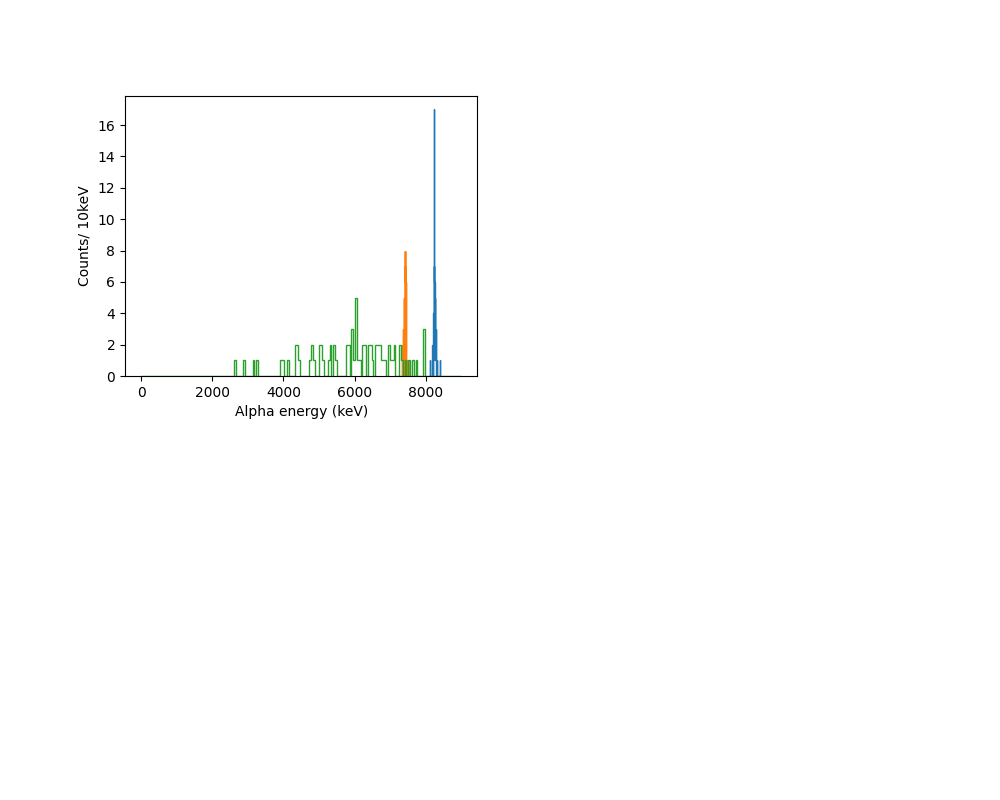

In [9]:
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_REAA['alpha1_xE'], histtype='step', bins=60, range=(8100,8400))
plt.hist(df_REAA['alpha2_xE'], histtype='step', bins=60, range=(7250,7550))
plt.hist(df_REAA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

# Decay KHS

Text(0, 0.5, 'Ln($\\Delta$t/ s)/ 10 keV')

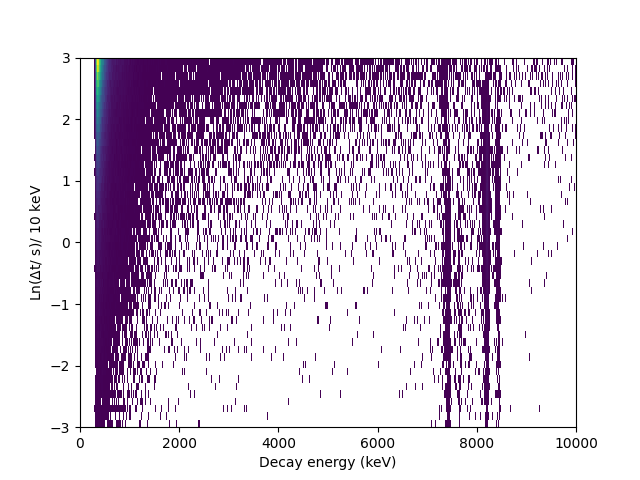

In [10]:
plt.figure()
plt.hist2d(decays['yE'], decays['log_dt'], 
           bins=((500),(50)), range=((0,10000),(-3,3)), cmin=1)
plt.xlabel('Decay energy (keV)')
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV')




# electron half-life

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Conversion factors for displaying half-life in different units
_UNIT_CONVERSION = {
    's': 1,       # seconds
    'ms': 1e3,    # milliseconds
    'us': 1e6,    # microseconds
    'min': 1/60,  # minutes
    'h': 1/3600   # hours
}


def fit_log_dt_decay(df, t1_col, t2_col, initial_guess,
                     bins=50, hist_range=(-10, 3), num_theta=500,
                     bounds=([0, 0], [np.inf, np.inf]), ax=None,
                     color=None, display_unit='s',
                     plot_data_kwargs=None, plot_fit_kwargs=None):
    """
    Histogram + exponential fit in log(dt) space, with optional plotting.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset.
    t1_col, t2_col : str
        Column names for computing dt = df[t1_col] - df[t2_col].
    initial_guess : sequence of two floats [lambda_guess, n0_guess]
        Initial parameter guesses for curve fitting.
    bins : int
        Number of histogram bins.
    hist_range : tuple
        (min, max) range for log(dt) histogram.
    num_theta : int
        Number of points for the smooth fit curve.
    bounds : 2×2 array-like
        Parameter bounds for scipy.optimize.curve_fit.
    ax : matplotlib.axes.Axes or None
        Axes on which to plot; if None, no plotting is done.
    color : str or None
        Color string for plotting data and fit.
    display_unit : str, optional
        Unit for displaying half-life in the legend. Must be one of:
        's', 'ms', 'us', 'min', 'h'. Default is 's'.
    plot_data_kwargs : dict or None
        Additional kwargs for ax.errorbar.
    plot_fit_kwargs : dict or None
        Additional kwargs for ax.plot of the fit curve.

    Returns
    -------
    result : dict
        Contains histogram, fit parameters, half-life in seconds, and fit curve.
    """
    # Validate display_unit
    if display_unit not in _UNIT_CONVERSION:
        raise ValueError(f"Unsupported display_unit '{display_unit}'. "
                         f"Choose from {list(_UNIT_CONVERSION.keys())}.")

    # 1. Compute log(dt) and histogram
    log_dt = np.log(df[t1_col] - df[t2_col])
    hist, edges = np.histogram(log_dt, bins=bins, range=hist_range)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # 2. Mask zero-count bins
    mask = hist > 0
    x = centers[mask]
    y = hist[mask]

    # 3. Define model PDF in theta = ln(dt)
    def _pdf(theta, lam, n0):
        dt = np.exp(theta)
        return n0 * lam * dt * np.exp(-lam * dt)

    # 4. Curve fitting
    popt, pcov = curve_fit(_pdf, x, y, p0=initial_guess, bounds=bounds)
    lam_fit, n0_fit = popt
    lam_err = np.sqrt(np.diag(pcov))[0]

    # 5. Compute half-life and error in seconds
    t_half_sec = np.log(2) / lam_fit
    t_half_err_sec = (np.log(2) / lam_fit**2) * lam_err

    # 6. Convert to desired display unit
    factor = _UNIT_CONVERSION[display_unit]
    t_half_disp = t_half_sec * factor
    t_half_err_disp = t_half_err_sec * factor

    # 7. Build smooth fitted curve
    theta_fit = np.linspace(edges.min(), edges.max(), num_theta)
    fit_curve = _pdf(theta_fit, lam_fit, n0_fit)

    result = {
        'bin_centres': centers,
        'hist': hist,
        'fit_mask': mask,
        'fit_bin_centres': x,
        'popt': popt,
        'pcov': pcov,
        't_half_sec': t_half_sec,
        't_half_err_sec': t_half_err_sec,
        't_half_disp': t_half_disp,
        't_half_err_disp': t_half_err_disp,
        'disp_unit': display_unit,
        'theta_fit': theta_fit,
        'fit_curve': fit_curve,
    }

    # 8. Optional plotting
    if ax is not None:
        # Default plotting kwargs
        pdkw = {'fmt': 'o', 'yerr': np.sqrt(hist + 1), 'capsize': 2, 'ms': 4}
        pfkw = {'lw': 2}
        if color is not None:
            pdkw['color'] = color
            pfkw['color'] = color
        if plot_data_kwargs:
            pdkw.update(plot_data_kwargs)
        if plot_fit_kwargs:
            pfkw.update(plot_fit_kwargs)

        # Plot histogram and fit
        ax.errorbar(centers, hist, alpha=0.3, **pdkw)
        ax.step(centers, hist, where='mid', alpha=0.6,
                color=color if color is not None else pdkw.get('color'))
        unit_label = display_unit
        ax.plot(theta_fit, fit_curve, **pfkw,
                label=f"T₁/₂ = {t_half_disp:.2f} ± {t_half_err_disp:.2f} {unit_label}")

    return result


def plot_multiple_decay_fits(datasets, figsize=(6,4),
                             bins=50, hist_range=(-10, 3),
                             num_theta=500, bounds=([0, 0], [np.inf, np.inf]),
                             display_unit='s'):
    """
    Plot several decay-fits on one axes, each with a consistent color and unit.

    Parameters
    ----------
    datasets : list of dicts
        Each dict should contain:
        - 'df': pandas.DataFrame
        - 't1_col', 't2_col': column names
        - 'initial': [lambda_guess, n0_guess]
        - 'label': str for legend entry
        - 'linestyle': optional linestyle for fit curve
    figsize : tuple
        Figure size in inches.
    bins, hist_range, num_theta, bounds : passed to fit function.
    display_unit : str
        Unit for T₁/₂ display (same options as fit_log_dt_decay).

    Returns
    -------
    fig, ax : matplotlib Figure and Axes with overlaid fits.
    """
    # Validate display_unit
    if display_unit not in _UNIT_CONVERSION:
        raise ValueError(f"Unsupported display_unit '{display_unit}'. "
                         f"Choose from {list(_UNIT_CONVERSION.keys())}.")

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel('log(dt / s)')
    ax.set_ylabel('Counts')

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for idx, data in enumerate(datasets):
        color = colors[idx % len(colors)]
        res = fit_log_dt_decay(
            df=data['df'],
            t1_col=data['t1_col'],
            t2_col=data['t2_col'],
            initial_guess=data['initial'],
            bins=bins,
            hist_range=hist_range,
            num_theta=num_theta,
            bounds=bounds,
            ax=ax,
            color=color,
            display_unit=display_unit,
            plot_data_kwargs={'label': data.get('label')},
            plot_fit_kwargs={'linestyle': data.get('linestyle', '-')}
        )

    ax.legend(title=f"T₁/₂ [{display_unit}]")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig, ax


# Electron half life

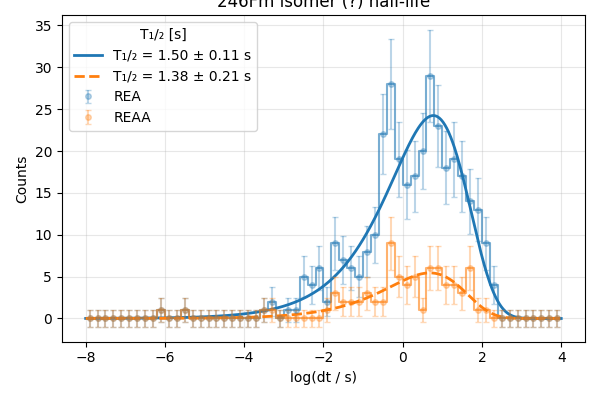

In [12]:
# # Define your list of data‐settings:
fm246_isomer = [
    {
      'df': df_REA,
      't1_col': 'electron1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/1.0, 100],  
      'label': 'REA',
      'linestyle': '-'                   
    },
    {
      'df': df_REAA,
      't1_col': 'electron1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/1, 20],
      'label': 'REAA',
      'linestyle': '--'
    },

]

fig, ax = plot_multiple_decay_fits(fm246_isomer,
                                   bins=60,
                                   hist_range=(-8,4))
plt.title("246Fm isomer (?) half-life")
plt.show()


# 246 Fm half life

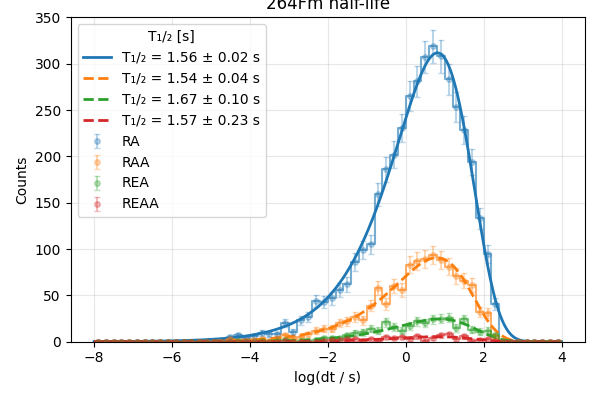

In [13]:
# # Define your list of data‐settings:
fm246 = [
    {
      'df': df_RA,
      't1_col': 'alpha1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/1.5, 100],   # lambda guess, n0 guess
      'label': 'RA',
      'linestyle': '-'                   
    },
    {
      'df': df_RAA,
      't1_col': 'alpha1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/1.5, 20],
      'label': 'RAA',
      'linestyle': '--'
    },
    {
      'df': df_REA,
      't1_col': 'alpha1_t',
      't2_col': 'electron1_t',
      'initial': [np.log(2)/1.5, 20],
      'label': 'REA',
      'linestyle': '--'
    },
    {
      'df': df_REAA,
      't1_col': 'alpha1_t',
      't2_col': 'electron1_t',
      'initial': [np.log(2)/1.5, 20],
      'label': 'REAA',
      'linestyle': '--'
    },

]

fig, ax = plot_multiple_decay_fits(fm246,bins=60,hist_range=(-8,4))
plt.ylim(0,350)
plt.title("264Fm half-life")
plt.show()


# 242 Cf half life

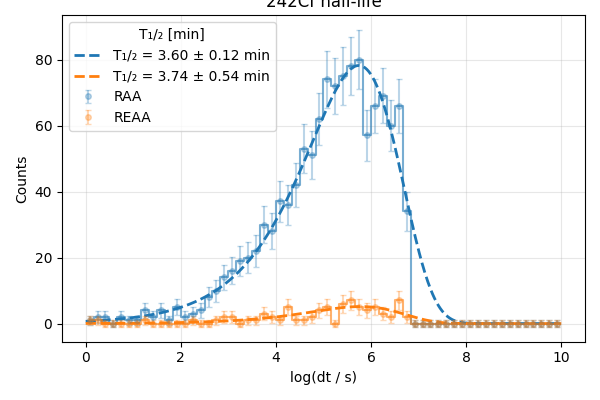

In [14]:
# # Define your list of data‐settings:
cf242 = [
    {
      'df': df_RAA,
      't1_col': 'alpha2_t',
      't2_col': 'alpha1_t',
      'initial': [np.log(2)/(3.5*60), 20],
      'label': 'RAA',
      'linestyle': '--'
    },
        {
      'df': df_REAA,
      't1_col': 'alpha2_t',
      't2_col': 'alpha1_t',
      'initial': [np.log(2)/(3.5*60), 20],
      'label': 'REAA',
      'linestyle': '--'
    },

]

fig, ax = plot_multiple_decay_fits(cf242,bins=60,hist_range=(0,10),display_unit='min')
# plt.ylim(0,350)
plt.title("242Cf half-life")
plt.show()


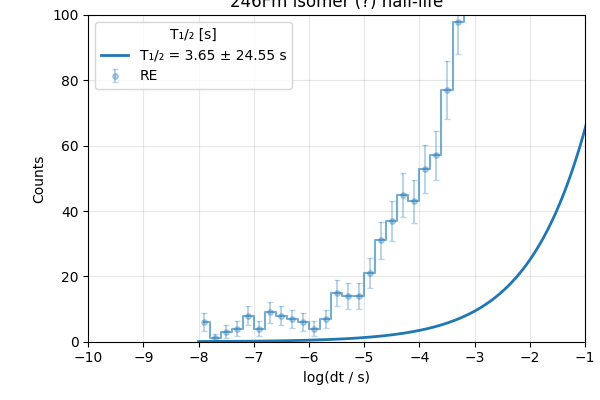

In [15]:
# # Define your list of data‐settings:
test = [
    {
      'df': df_RE,
      't1_col': 'electron1_t',
      't2_col': 'recoil_t',
      'initial': [np.log(2)/5, 1000],  
      'label': 'RE',
      'linestyle': '-'                   
    },

]

fig, ax = plot_multiple_decay_fits(test,
                                   bins=60,
                                   hist_range=(-8,4))
plt.title("246Fm isomer (?) half-life")
plt.xlim(-10,-1)
plt.ylim(0,100)
plt.show()
